Exercise 1

1. Generate strings of length 15 over the alphabet a, b, c, d

2. Label your strings basing on matching a 5-element regular expression

3. Balance your dataset of size 10000 so that approximately half of the dataset contains regex-matching parts.

4. Prepare your data for training using one-hot encoding

5. Divide your dataset into training and testing parts.

6. Implement and train a model consisting of one convolutional layer with one filter followed by one fully-connected layer and train it to classify your strings. After training, examine the values of the filter

7. Implement and train more complex models (more filters, layers) and analyze their performance on the prepared dataset.

In [1399]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
def generate_string(length = 15, alphabet = "abcd", pattern = "cabad", contains = True):
      
      pattern_len = len(pattern)
      if contains: 
            # we need to generate prefix and sufix to our pattern both might be 0 lentgth ofc 
            prefix_len = random.randint(0,length - pattern_len)
            suffix_len = length - pattern_len - prefix_len
            prefix = ''.join(random.choices("abcd" , k=prefix_len))
            suffix = ''.join(random.choices("abcd" , k=suffix_len))
            return prefix + pattern + suffix
      else: 
            while True:
                  candidate = ''.join(random.choices("abcd" , k=length))
                  if pattern not in candidate:
                        return candidate
def generate_dataset(size = 10000):
      expressions = []
      labels = []
      half = size // 2
      
      
      for _ in range(half):
            expressions.append(generate_string(length=15,alphabet="abcd",pattern="cabad",contains=True))
            labels.append(1)
      for _ in range(size- half):
            expressions.append(generate_string(length=15,alphabet="abcd",pattern="cabad",contains=False))
            labels.append(0)
            
      return pd.DataFrame({"expressions":expressions,"contains_abcd":labels})

In [1400]:
generate_string(contains=False)

'cbbabaacccaacab'

In [1401]:
df = generate_dataset()

In [1402]:
df

,expressions,contains_abcd
0,bbcabaddbabaadc,1
1,bcabaddabacbdda,1
2,dcccdcccabadbcd,1
3,addbcabadaabdcc,1
4,cabadcbaccddccd,1
...,...,...
9995,acbcbaddacbadbd,0
9996,abcaabacacdadbd,0
9997,abbdacdaabadbcc,0
9998,bbdbdbcbbbadaaa,0


In [1403]:
char_indexes = {'a':0,'b':1,'c':2,'d':3}
num_classes = 4

In [1404]:
def one_hot_encode_expression(s,map,num_classes):
    one_hot = torch.zeros(size = (len(s),num_classes))
    for i, char in enumerate(s):
        one_hot[i,map[char]] = 1 
    return one_hot
def one_hot_encode_dataset(dataset,shape,map):
    table = torch.empty(size = shape)
    for i,s in enumerate(dataset.iloc[:,0]):
        table[i] = one_hot_encode_expression(s,map = map,num_classes= shape[-1])
    return table

In [1405]:
def decode_character(char,characters = ['a','b','c','d']):
    index = torch.argmax(char)
    return characters[index]

def decode_string(dataset, index):
    expression = ""
    for letter in dataset[index]:
        expression += decode_character(letter)
    return expression

In [1406]:
s = generate_string()

In [1407]:
one_hot_encode_expression(s,char_indexes,num_classes)

tensor([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]])

In [1408]:
dataset = torch.empty(size = (10000,15,4))

In [1409]:
def one_hot_encode_dataset(dataset,shape,map):
    table = torch.empty(size = shape)
    for i,s in enumerate(dataset.iloc[:,0]):
        table[i] = one_hot_encode_expression(s,map = map,num_classes= shape[-1])
    return table

In [1410]:
X = one_hot_encode_dataset(dataset=df,shape = (10000,15,4),map =char_indexes)

In [1411]:
decode_string(dataset=X,index=5000) == df.iloc[5000,0]  # to make sure that one hot encoding works correctly 

True

In [1412]:
y = torch.tensor(data=df.iloc[:,1])  

In [1413]:
y_oh = torch.nn.functional.one_hot(y,num_classes=2)  # it will be probably useful to keep labels in both vector and one hot tensor form 

In [1414]:
from sklearn.model_selection import train_test_split

In [1415]:
X_train , X_test , y_train , y_test = train_test_split(X.view(10000,4,15),y,test_size=0.2)  # to have shape as desired by pytorch

In [1416]:
X_train[:5].view(5,15,4),y_train[:5]

(tensor([[[1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.]],
 
         [[0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.]],
 
         [[0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [0.,

In [1417]:
y_train_oh , y_test_oh = nn.functional.one_hot(y_train,num_classes=2).type(torch.float32) , nn.functional.one_hot(y_test,num_classes=2).type(torch.float32)  # it will be probably useful to keep labels in both vector and one hot tensor form 

In [1418]:
y_train[:2],y_train_oh[:2]

(tensor([1, 0]),
 tensor([[0., 1.],
         [1., 0.]]))

In [1419]:
X_train.shape

torch.Size([8000, 4, 15])

In [1420]:
X_train

tensor([[[1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 1., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1

In [1421]:
y_train

tensor([1, 0, 1,  ..., 0, 0, 0])

In [1422]:
# create simple conv model 
class SimpleConvNet(nn.Module):
    # in channels is equal to number of alphabet letters from which dataset is constructed 4 in case of abcd 
    # 1 out channels = one filter 
    # let's go with kernel size equal to pattern length 5 in oour case
    def __init__(self,num_chars,pattern_len):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=num_chars , out_channels = 1,kernel_size= pattern_len,bias = False),
                                   nn.ReLU())
        self.fc = nn.Linear(in_features=11,out_features=2,bias= False)
    def forward(self,x):
        x = self.conv1(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

In [1423]:
model = SimpleConvNet(num_chars=4,pattern_len=5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.BCEWithLogitsLoss()

In [1424]:
X_train.shape

torch.Size([8000, 4, 15])

create custom dataset 

In [1425]:
from torch.utils.data import DataLoader, TensorDataset

    
# Create Dataset instances
train_dataset = TensorDataset(X_train, y_train_oh)
test_dataset = TensorDataset(X_test, y_test_oh)




In [1426]:
batch_size = 10
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [1490]:
def train(model,
          dataloader,
          loss_fn,
          optimizer,
          epochs = 10):
    
    for epoch in range(epochs):
    # put model in train mode
    

      
      # setrup train loss and accuracy 
      model.train()
      train_loss , train_acc = 0,0
      # loop through dataloader in batches 
      for batch, (X,y) in enumerate(dataloader):
            

            # forward pass
            y_pred = model(X)
          
            # calcualte loss 
            loss = loss_fn(y_pred,y)
            train_loss += loss.item()
            
            # zero grad
            optimizer.zero_grad()
            
            # loss backward 
            loss.backward()
            
            # optimizer step 
            
            optimizer.step()
        
           
            # Adjust metrics to get average loss  per batch 
      train_loss = train_loss / len(dataloader)
      
      print(f"Epoch{epoch} | train loss {train_loss}")

          

In [1437]:
train(model=model,
      dataloader=train_dataloader,
      loss_fn=loss,
      optimizer=optimizer,
      epochs=10000)

Epoch0 | train loss 0.6162455262988806
Epoch1 | train loss 0.6159301717579365
Epoch2 | train loss 0.6156205464154482
Epoch3 | train loss 0.6153219208866357
Epoch4 | train loss 0.6150265320762992
Epoch5 | train loss 0.6147287131100893
Epoch6 | train loss 0.6144331711158156
Epoch7 | train loss 0.6141345789283514
Epoch8 | train loss 0.6138305127993227
Epoch9 | train loss 0.6135298562794924
Epoch10 | train loss 0.6132428694516421
Epoch11 | train loss 0.6129669805243612
Epoch12 | train loss 0.6127045322209597
Epoch13 | train loss 0.6124401993304491
Epoch14 | train loss 0.6121680257096886
Epoch15 | train loss 0.6118951651081442
Epoch16 | train loss 0.6116393000632524
Epoch17 | train loss 0.6113893457129598
Epoch18 | train loss 0.6111458441615105
Epoch19 | train loss 0.6109024115279317
Epoch20 | train loss 0.6106596566736698
Epoch21 | train loss 0.6104140988737344
Epoch22 | train loss 0.6101668963581324
Epoch23 | train loss 0.6099217769131065
Epoch24 | train loss 0.6096788489446044
Epoch25 | 

In [1438]:
y_test_pred = model(X_test).argmax(dim=1)

In [1439]:
def accuracy_fn(y_pred , y):
    counter = 0
    for i in range(len(y)):
        if y[i] != y_pred[i]:
            counter +=1
    return 1 - counter / len(y)

In [1440]:
accuracy_fn(y_test_pred,y_test)

0.6765

In [1441]:
params = model.state_dict()
kernel = params['conv1.0.weight'].view(4,5)

In [1442]:
kernel

tensor([[ 4.1089e-01, -9.4194e-04,  4.6231e-01, -6.4247e-01, -5.4503e-01],
        [ 4.9456e-01,  2.0058e+00,  2.1727e+00,  1.5817e+00, -1.9677e+00],
        [-4.1240e-02, -3.7818e+00, -2.9657e+00, -2.1808e+00, -1.9417e+00],
        [ 1.0392e+00,  1.0085e+00,  1.3716e-01,  2.6084e-01,  2.2983e-01]])

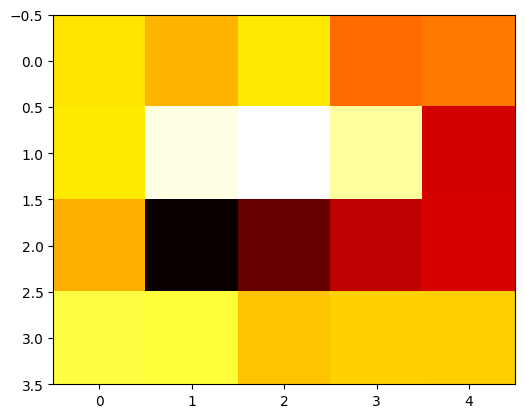

In [1443]:
import matplotlib.pyplot as plt
# Display the heatmap
plt.imshow(kernel, cmap='hot')
plt.show()

In [1502]:
# create more complex conv model 
class ComplexeConvNet(nn.Module):
    # in channels is equal to number of alphabet letters from which dataset is constructed 4 in case of abcd 
    # 1 out channels = one filter 
    # let's go with kernel size equal to pattern length 5 in oour case
    def __init__(self,num_chars,pattern_len):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=num_chars , out_channels = 15 ,kernel_size= pattern_len,bias = True),
                                   nn.ReLU(),
                                   nn.Conv1d(in_channels=15 , out_channels = 1 ,kernel_size= pattern_len,bias = True),
                                   nn.ReLU()
                                   )
        self.fc1 = nn.Linear(in_features=7,out_features=20,bias=True)
        self.fc2 = nn.Linear(in_features=20,out_features=2,bias= True)
    def forward(self,x):
        x = self.conv1(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [1503]:
model2 = ComplexeConvNet(num_chars=4,pattern_len=5)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001)
loss2 = nn.BCEWithLogitsLoss()

In [1504]:
train(model=model2,
      dataloader=train_dataloader,
      loss_fn=loss2,
      optimizer=optimizer2,
      epochs=10)

Epoch0 | train loss 0.6934448850899935
Epoch1 | train loss 0.6933103831857443
Epoch2 | train loss 0.6932147477567195
Epoch3 | train loss 0.6931394296139479
Epoch4 | train loss 0.6930762130767107
Epoch5 | train loss 0.6930173265188933
Epoch6 | train loss 0.6929600079357624
Epoch7 | train loss 0.6929032275825739
Epoch8 | train loss 0.6928449610620737
Epoch9 | train loss 0.6927801555395127
